In [1]:
import numpy as np
import math
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
import classical_newsvendor_utils

from os import listdir
from os.path import isfile, join

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

import joblib

In [2]:
scaler = joblib.load('scaler.gz')

tmean = torch.tensor(scaler.mean_.item())
tstd = torch.tensor(scaler.scale_.item())

In [3]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [4]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 42
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [5]:
noise_type = 'multimodal'

In [6]:
N_test = 3000

X, y = data_generator.data_1to1(N_test, noise_level=1, noise_type=noise_type)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [7]:
models_path = './models/'
csvs_path = './newsvendor_results/'
csv_names = [f for f in listdir(csvs_path) if (isfile(join(csvs_path, f)) and noise_type in f)]

In [8]:
df_results = pd.DataFrame()

for cn in csv_names:
    csv_name = cn
    model_name = cn.replace('csv','pkl')

    df_aux = pd.read_csv(csvs_path+csv_name)
    df_aux = df_aux.set_index('Unnamed: 0')
    df_aux.columns = [csv_name]
    
    df_results = pd.concat([df_results, df_aux], axis=1)

In [9]:
df_results.loc[0.8]

mse_nv1_01_multimodal_nr.csv            0.209
ann0_multimodal_nr.csv                  0.200
elbo2_nv1_10_50_multimodal_nr.csv     -21.737
mse_nv1_100_multimodal_nr.csv           0.197
elbo2_nv1_10_40_multimodal_nr.csv     -21.324
elbo2_nv1_3000_40_multimodal_nr.csv     0.203
elbo2_nv1_00_10_multimodal_nr.csv     -34.271
bnnbnn_multimodal_nr.csv                0.214
ann_combined_q0.2_multimodal_nr.csv     0.388
elbo_nv1_500_20_multimodal_nr.csv       0.202
elbo_nv1_10_20_multimodal_nr.csv        0.206
elbo2_nv1_1000_10_multimodal_nr.csv     0.183
elbo2_nv1_10_10_multimodal_nr.csv     -19.390
elbo2_nv1_02_20_multimodal_nr.csv     -21.803
elbo_nv1_100_20_multimodal_nr.csv       0.204
ann_combined_q0.8_multimodal_nr.csv     0.166
elbo2_nv1_1000_50_multimodal_nr.csv   -21.960
elbo2_nv1_500_40_multimodal_nr.csv      0.190
flowflow_multimodal_nr.csv              0.171
elbo2_nv1_00_00_multimodal_nr.csv     -20.366
elbo_nv1_3000_20_multimodal_nr.csv      0.197
bnn_combined_q0.8_multimodal_nr.cs

In [10]:
model_name_ann_dec = "ann0_multimodal.pkl"
model_name_ann_com02 = "ann_combined_q0.2_multimodal.pkl"
model_name_ann_com08 = "ann_combined_q0.8_multimodal.pkl"

model_name_bnn_dec = "bnn0.2_multimodal.pkl"
model_name_bnn_com02 = "bnn_combined_q0.2_multimodal.pkl"
model_name_bnn_com08 = "bnn_combined_q0.8_multimodal.pkl"

model_name_flow = "flow_multimodal.pkl"

In [11]:
model_name_ann_dec_model = torch.load(f'./models/{model_name_ann_dec}')
model_name_ann_com02_model = torch.load(f'./models/{model_name_ann_com02}')
model_name_ann_com08_model = torch.load(f'./models/{model_name_ann_com08}')

model_name_bnn_dec_model = torch.load(f'./models/{model_name_bnn_dec}')
model_name_bnn_com02_model = torch.load(f'./models/{model_name_bnn_com02}')
model_name_bnn_com08_model = torch.load(f'./models/{model_name_bnn_com08}')

model_flow = torch.load(f'./models/{model_name_flow}')

In [12]:
#model_mse.update_n_samples(1000)
model_name_bnn_dec_model.update_n_samples(200)
model_name_bnn_com02_model.update_n_samples(200)
model_name_bnn_com08_model.update_n_samples(200)

In [13]:
xt = torch.tensor(np.arange(-2.0, 2.0, 1/800), dtype = torch.float32)

In [14]:
y_pred_bnn_dec = model_name_bnn_dec_model.forward_dist(xt.unsqueeze(1))
y_pred_bnn_com02 = model_name_bnn_com02_model.forward_dist(xt.unsqueeze(1))
y_pred_bnn_com08 = model_name_bnn_com08_model.forward_dist(xt.unsqueeze(1))

In [15]:
M = 1000
N = xt.shape[0]

y_pred_flow = torch.zeros((M, N))

for i in range(0, N):
    y_pred_flow[:,i] = model_flow.condition(xt.unsqueeze(1)[i]).sample(torch.Size([M,])).squeeze()

In [16]:
y_pred_ann_dec = model_name_ann_dec_model(xt.unsqueeze(1))
y_pred_ann_com02 = model_name_ann_com02_model(xt.unsqueeze(1))
y_pred_ann_com08 = model_name_ann_com08_model(xt.unsqueeze(1))

In [17]:
def inverse_transform(y):
    return y*tstd + tmean
y_pred_ann_dec_orig = inverse_transform(y_pred_ann_dec)
y_pred_ann_com02_orig = inverse_transform(y_pred_ann_com02)
y_pred_ann_com08_orig = inverse_transform(y_pred_ann_com08)

y_pred_bnn_dec_orig = inverse_transform(y_pred_bnn_dec)
y_pred_bnn_com02_orig = inverse_transform(y_pred_bnn_com02)
y_pred_bnn_com08_orig = inverse_transform(y_pred_bnn_com08)

y_pred_flow_orig = inverse_transform(y_pred_flow)
#y_orig = inverse_transform(y)

In [18]:
def plot_regression(X, y, xt, y_pred, method, suffix, color_pred, noise_type):

    y_pred_np = y_pred.squeeze().detach().numpy()
    y_np = y.detach().numpy()
    
    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    
    if method in ['BNN', 'FLOW']:        
        for i in range(0, len(y_pred_np)):
            ax.scatter(xt.detach(), y_pred_np[i],
                        color=color_pred, alpha=0.01, s=0.05)
        ax.scatter(X[:,0].detach(), y_np, color='#004488', label='Groundtruth', s=8, alpha=0.2)
        
    elif method in ['ANN']:
        ax.scatter(X[:,0].detach(), y_np, color='#004488', label='Groundtruth', s=8, alpha=0.5)
        ax.scatter(xt.unsqueeze(1).detach().numpy(), 
                        y_pred_np, 
                        color=color_pred, 
                        alpha=0.8, 
                        s=3)
         
    else:
        print('Not a valid method')
        exit()
        
    
    ax.set_xlabel('Input')
    ax.set_ylabel('Output (Demand)')

    legend_elements = [Line2D([0], [0], color=color_pred, lw=2, label='Pred. Output'),
                   Line2D([0], [0], marker='o', color='w', label='Groundtruth',
                          markerfacecolor='#004488', markersize=15)]

    ax.legend(handles=legend_elements, loc='upper right')
    fig.savefig(f'./figures/regression_{method}_{suffix}_{noise_type}.png')

In [19]:
'#EE3377', '#CC3311', '#EE7733'

('#EE3377', '#CC3311', '#EE7733')

In [20]:
xt.shape

torch.Size([3200])

In [21]:
y_pred_ann_dec_orig.shape

torch.Size([3200, 1])

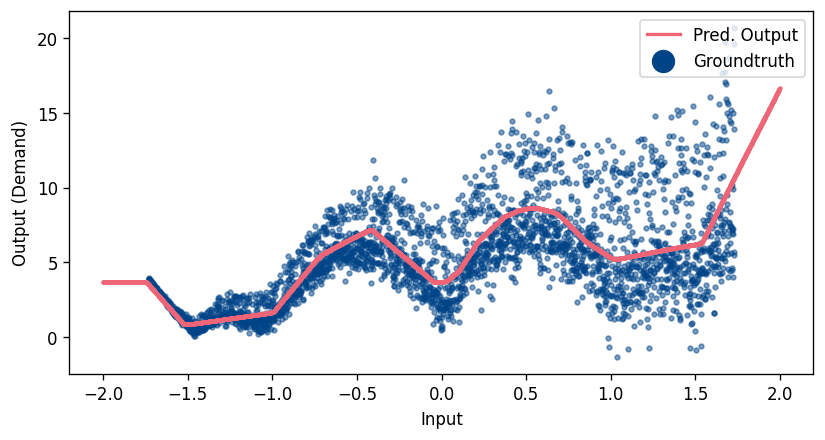

In [22]:
plot_regression(X, y, xt, y_pred_ann_dec_orig, 'ANN', '' '#EE6677', noise_type)

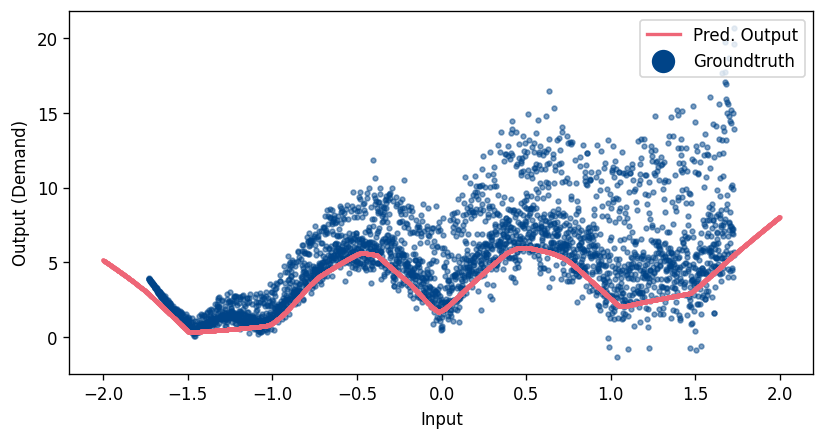

In [23]:
plot_regression(X, y, xt, y_pred_ann_com02_orig, 'ANN', '#EE6677', noise_type)

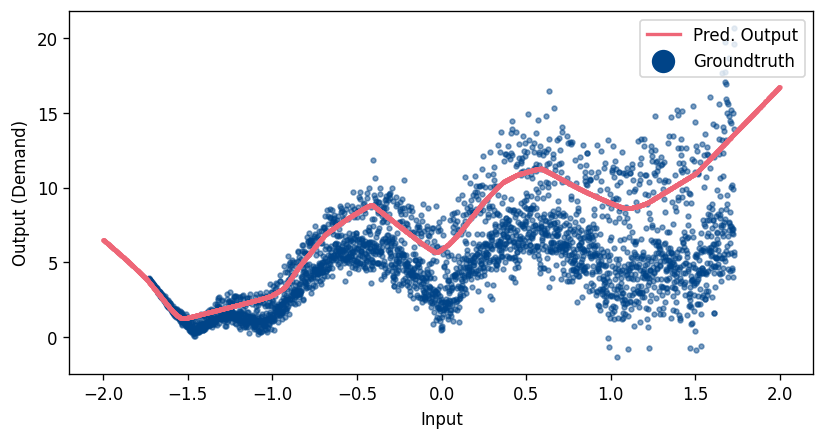

In [24]:
plot_regression(X, y, xt, y_pred_ann_com08_orig, 'ANN', '#EE6677', noise_type)

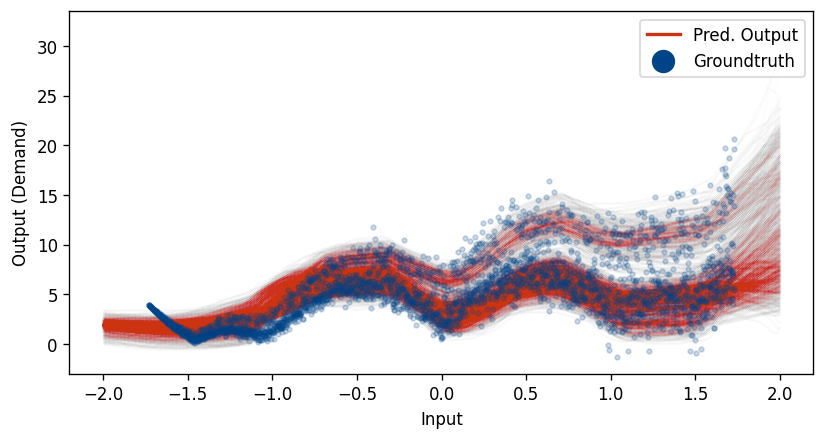

In [25]:
plot_regression(X, y, xt, y_pred_bnn_dec_orig, 'BNN', '#CC3311', noise_type)

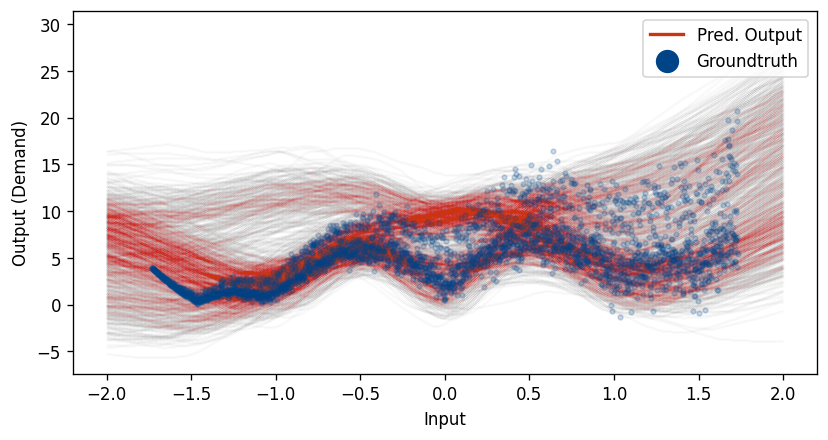

In [26]:
plot_regression(X, y, xt, y_pred_bnn_com02_orig, 'BNN', '#CC3311', noise_type)

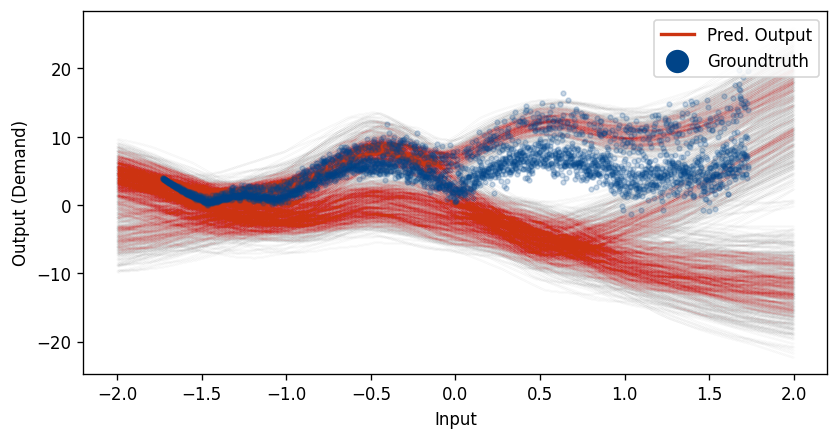

In [27]:
plot_regression(X, y, xt, y_pred_bnn_com08_orig, 'BNN', '#CC3311', noise_type)

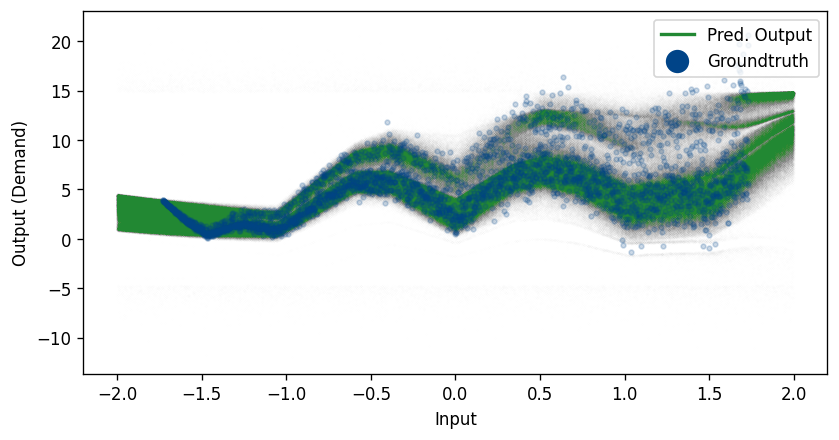

In [28]:
plot_regression(X, y, xt, y_pred_flow_orig, 'FLOW', '#228833', noise_type)

In [ ]:
result_file_mse
result_file_bnn_bayes
result_file_flow

In [56]:
df_results[result_file_mse].keys().tolist()

[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

In [ ]:
'#EE3377', '#CC3311', '#EE7733'

def compute_nv_curve(X, y, model, M=1000):
    sell_price = 200
    dict_results_nr = {}
    for cost_price in (np.arange(0.1,0.9,0.03)*sell_price):
        quantile = (sell_price-cost_price)/sell_price
        dict_results_nr[quantile] = round(
            classical_newsvendor_utils.compute_norm_regret(
            X, y, model, M, sell_price, cost_price).item(), 
            3)
    return dict_results_nr

nr_ann = compute_nv_curve(X, y, model_mse, M=1000)
nr_ann_noise = compute_nv_curve(X, y, model_mse_noise, M=1000)
nr_bnn = compute_nv_curve(X, y, model_bnn_bayes, M=1000)

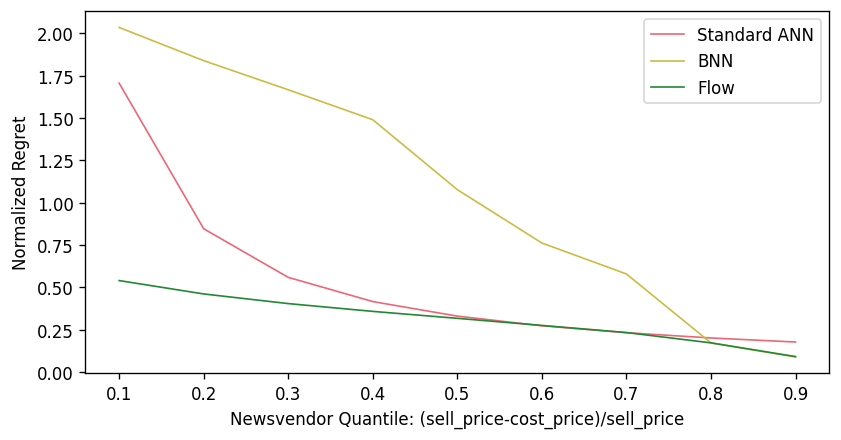

In [104]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
ax.plot(df_results[result_file_mse].keys().tolist(), 
        df_results[result_file_mse].values.tolist(), 
        color='#EE6677', label='Standard ANN', linewidth=1)

ax.plot(df_results[result_file_bnn_bayes].keys().tolist(), 
        df_results[result_file_bnn_bayes].values.tolist(), 
        color='#CCBB44', label='BNN', linewidth=1)

ax.plot(df_results[result_file_flow].keys().tolist(), 
        df_results[result_file_flow].values.tolist(),
        color='#228833', label='Flow', linewidth=1)

ax.legend()

ax.set_ylabel('Normalized Regret')
ax.set_xlabel('Newsvendor Quantile: (sell_price-cost_price)/sell_price')
fig.savefig('./figures/newsvendor_quantile_curve.png')